# Instructions for Running the Jupyter Notebook
The main Jupyter/Google Colab notebook for this problem statement is 'final_pipeline.ipynb' and
it is divided into 6 sections. In the first section, the relevant libraries are installed and the models
are loaded. The dependencies were selected with consideration to the Google Colab
environment. It is important to upload the models directly in the '/content/' location and ensure
that the correct paths to the models are provided in the third cell. To initialise the different
variables and functions, all cells should be run once in the beginning. The last two sections
contain the inference function and digitization functions, which are to be called by passing the
location of the image as the parameter.

# Abstract
Medical vitals extraction from an image is a crucial yet time-consuming process. With the
growing popularity and efficacy of Artificial Intelligence (AI), a large section of the community
has started working on automating different healthcare activities, such as medical entity
extraction and X-ray processing. In this work, we propose and build a transfer learning-based
object segmentation incorporating a vital extraction model, which takes a monitor as input and
outputs different medical vitals like oxygen and heart rate. The model first identifies the monitor
segment, marks the region of interest for vitals, and finally recognizes the marked boxes with
their respective vital labels. Our proposed model is a pipelined approach that helps to locate
errors effectively and scale up easily. With the proposed model, we found that our model
identifies different vitals with reliable confidences ranging from 0.9 to 0.97. We also did a
thorough human evaluation, showing that our model can handle different uncertainties like
monitor angle, shape, and background colour.

# Architecture:
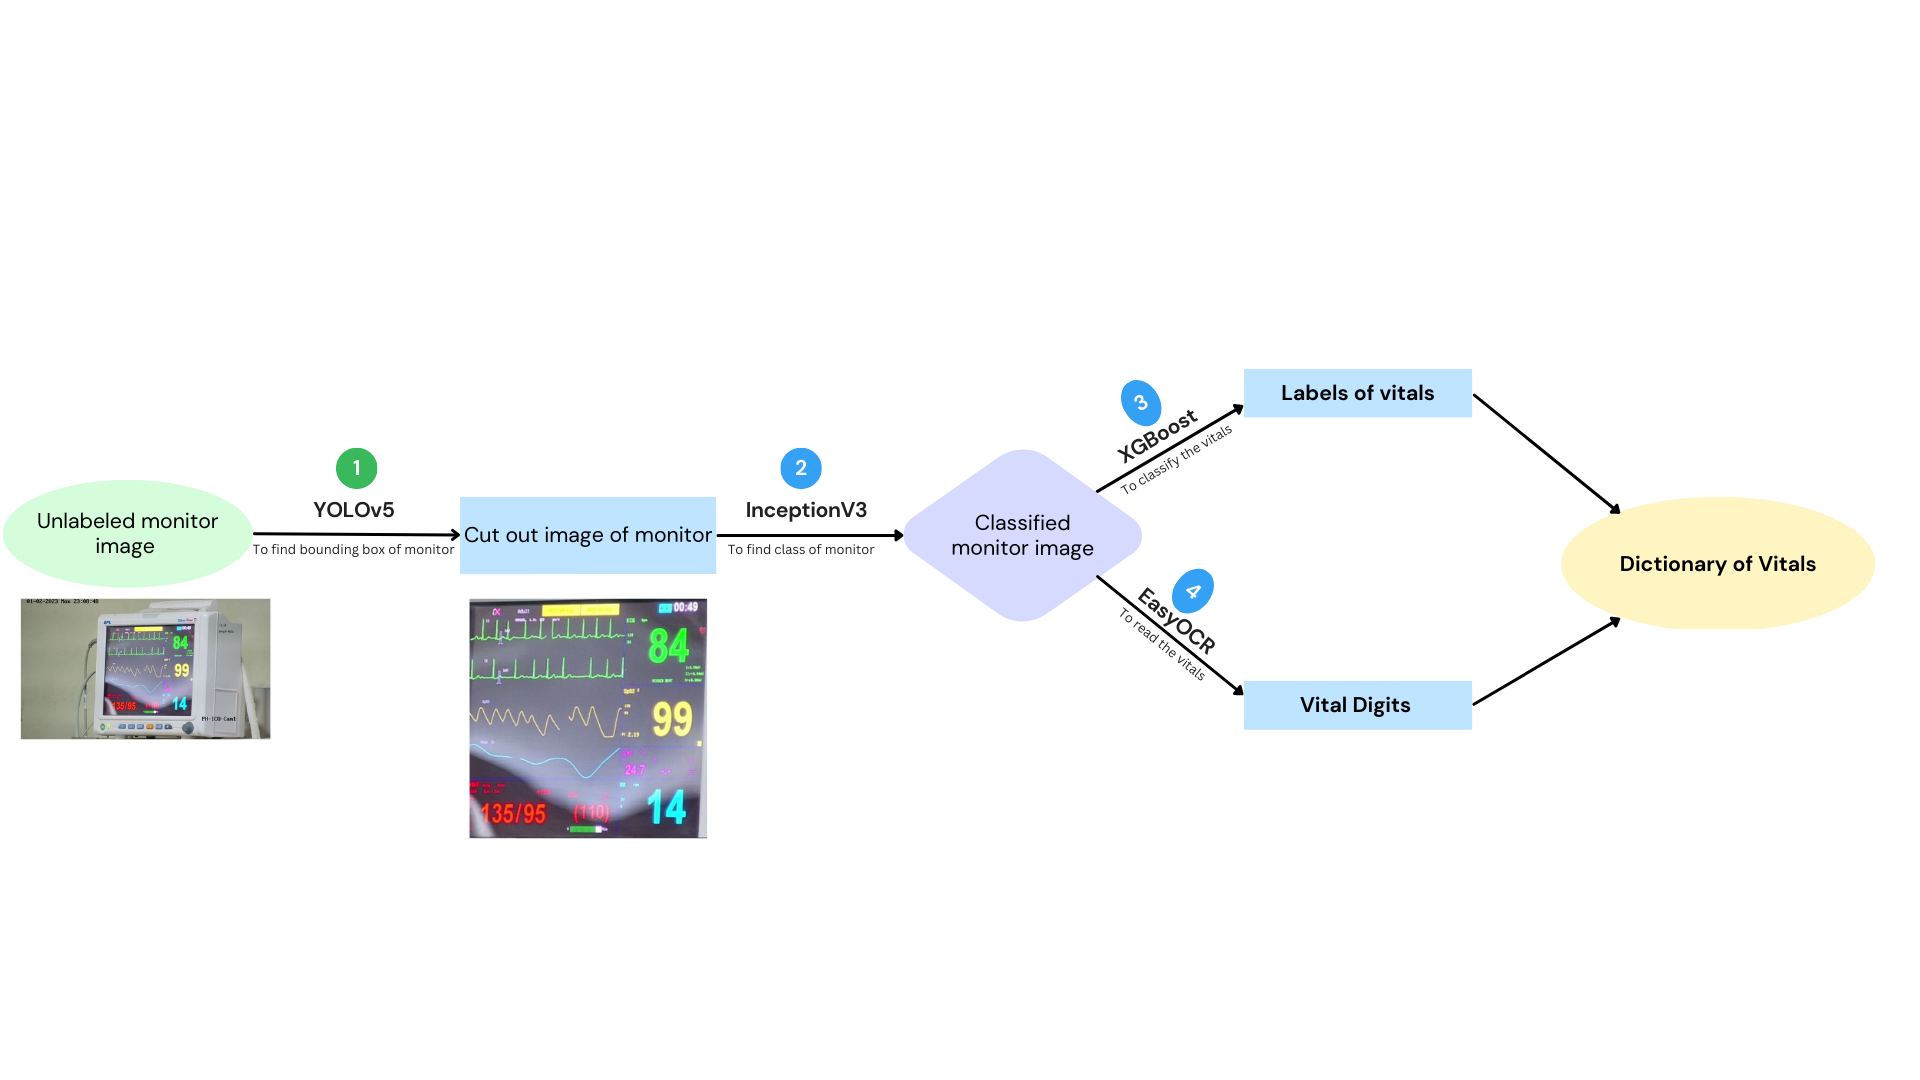
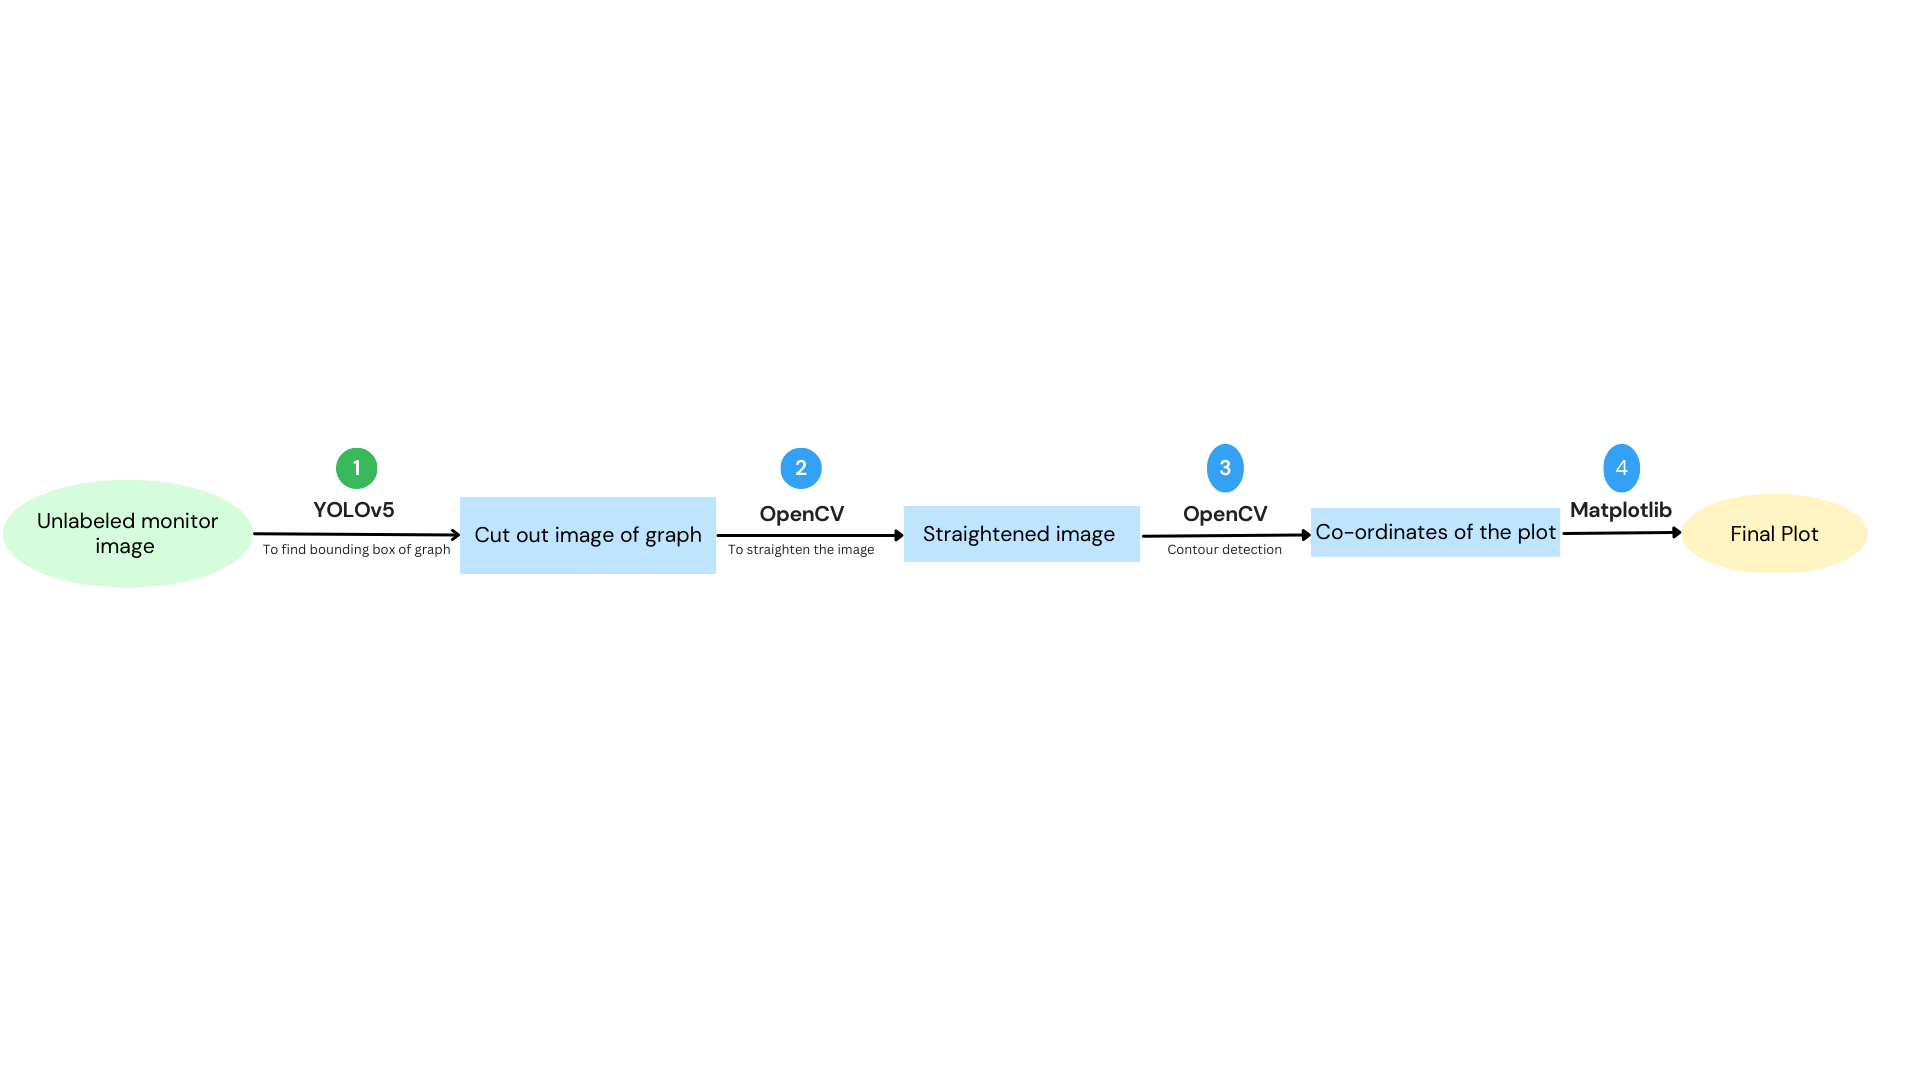

## Brief Description
The model emulates the process of human vision in reading vitals. Like how a human would first
locate the monitor, then determine its type, identify digits based on position, size and colour, the
model follows the same process to accurately classify and report the readings. It starts by
detecting the monitor screen, classifying it based on the cropped image, and then using the
location of the digits to label the data which is then passed on to the OCR for reading and
reporting the results.

## Monitor Segmenter
To identify the monitor from an image, we used YOLOv5 (You Only Look Once) which is a state
of the art model for quick object detection. The model will give us the x-center, y-center, height,
and width of the monitor it has detected, then we select the one with the maximum confidence
score and crop out the monitor and pass it to later stages.

## Monitor Classifier
Once we found the bounding box of the monitor, we classified the monitor into four classes by
using K-means clustering. For this we used a deep learning model, Inception V3 which is based
on CNNs. This is documented as the image_feature function in the final pipeline which gives us
the label of the monitor as output. Using unsupervised learning through Inception V3 introduced
some novelty in our pipeline.

## Digit Segmenter
To detect digits in monitor images, we utilised the YOLOv5 object detection system. This system
is designed for real-time object detection and is known for its speed and accuracy. The YOLOv5
model (loaded as digit_segmenter in the Colab notebook) was used to obtain the x-center,
y-center, height, and width of the detected digits. To prevent false positives, only the top 6 digits
were selected based on their confidence scores and were then cropped for further processing.

## Vital Classification
The digit's location and size information obtained from the previous step is fed into an XGBoost
classifier to predict its vital type. XGBoost, a flexible and powerful ML model, uses decision
trees as its base learner and improves predictions through gradient boosting. This results in
accurate vital type classification based on digit position and size. The final dictionary object is
then easily populated with the key-value pairs obtained from OCR.

## OCR
To detect text from images of various vitals, an OCR system is used. We used EasyOCR, which
employs deep learning algorithms for accurate and efficient text recognition. The final result is
returned in the form of a dictionary object.

## Heart Rate Digitization
We trained a separate YOLOv5 model on the whole Classification Dataset to give HR graph
coordinates. We cropped the obtained image of the graph and used the Contour Detection
method to extract the coordinates of the graph using OpenCV library. Contour detection can be
explained simply as a curve joining all the continuous points (along with the boundary), having
the same colour or intensity. We did not use edge detection since it has some limitations. One of
the major limitations being, it cannot detect the whole graph if there is some noise present in
between the curve, of which we saw multiple examples. We plotted the obtained coordinates
using Matplotlib.

# Training and Other Details

## Monitor Segmenter
To train the model we trained the yolov5 model on the 1800 of the 2000 image samples
provided and tested the model on the other 200 data. The training was done at 25 epoch with a
batch size of 8.
The following table summarises the efficacy of the model
- Precision: 0.991
- Recall: 1
- mAP50: 0.995 
- mAP50-95: 0.99

## Monitor Classifier
We first tried using Microsoft’s Resnet-18 Convolutional Architecture for Monitor Classification,
but we realised we should be taking Monitor Layout as the key attribute/feature instead of
Monitor Type for classifying and this would be done better on unsupervised learning than
supervising it to only Monitor Types, so we switched to Inception V3. Using K-means clustering
through Inception V3, we were able to get 100% test and train accuracy on the given 1000
monitor classification images. We used this cluster data in our final pipeline.

## Digit Segmenter
The objective of the model was to make it machine agnostic, hence we trained it on all four
classification datasets provided and treated all the vitals as the same class. To maximise digit
detection, the model was trained with a batch size of 10 and for 30 epochs. However, a
challenge arose when the model sometimes labelled the background as digits. To overcome
this, only the top 6 scores with the highest confidence were considered for digit classification.

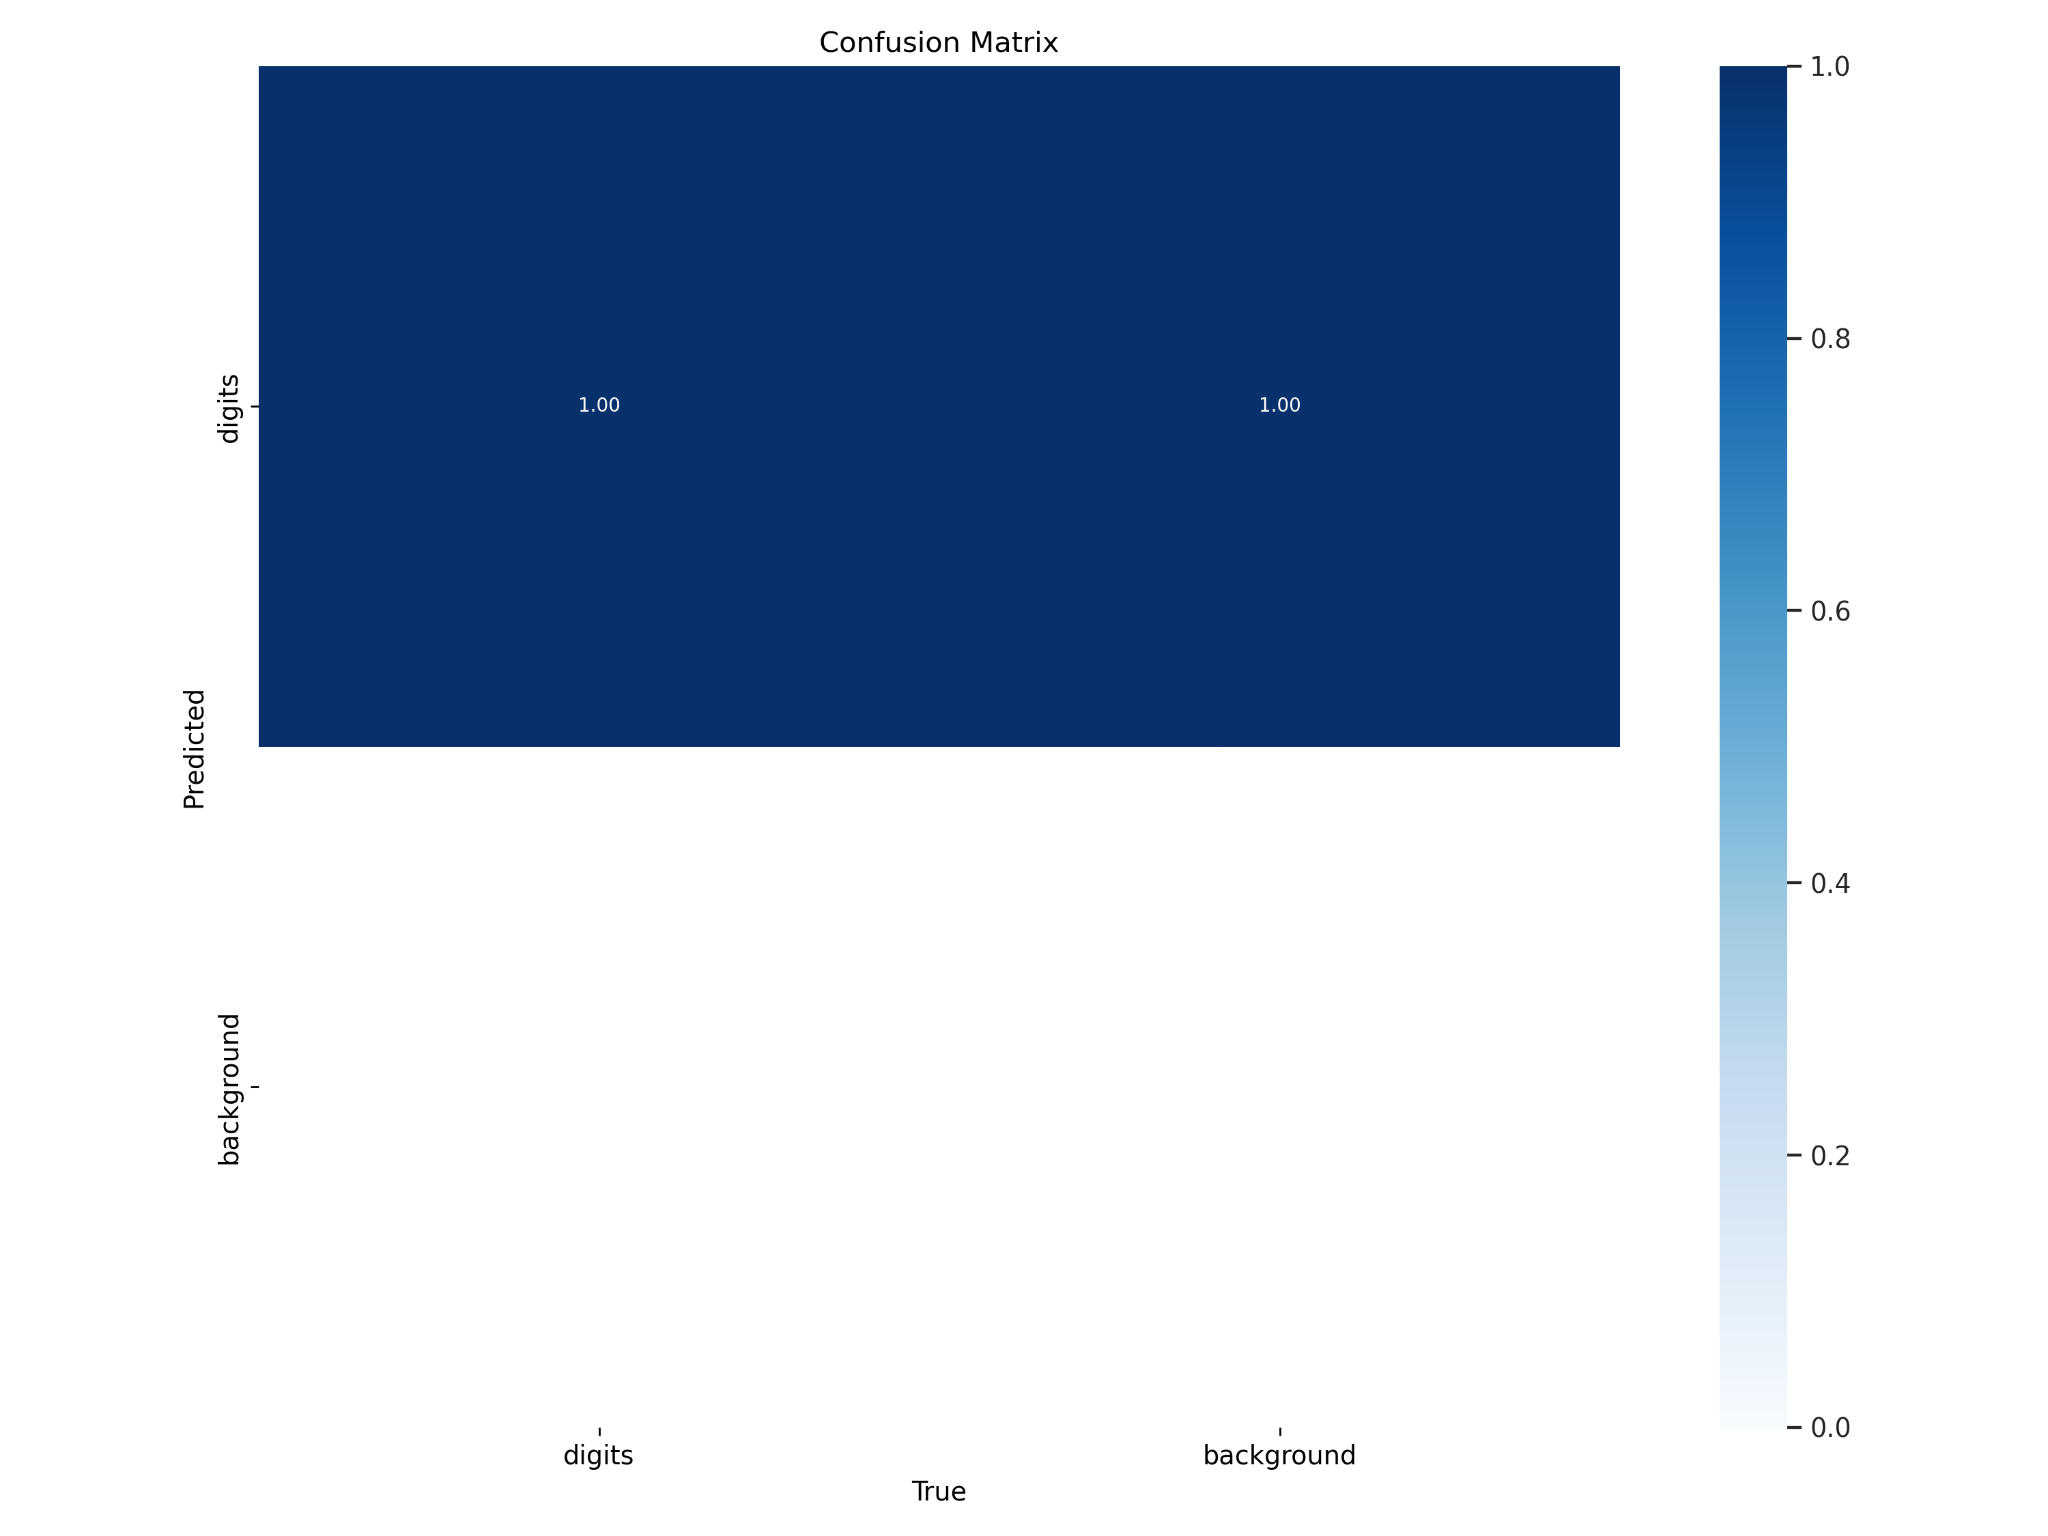

The following table tabulates the validation parameters-
- metrics/recall: 0.99627
- metrics/mAP_0.5: 0.9942 
- metrics/mAP_0.5:0.95: 0.80342 
- val/box_loss: 0.015804

In our initial attempts we tried to get yolo to both segment and classify the labels. However the
results were discouraging and hence we abandoned this approach.

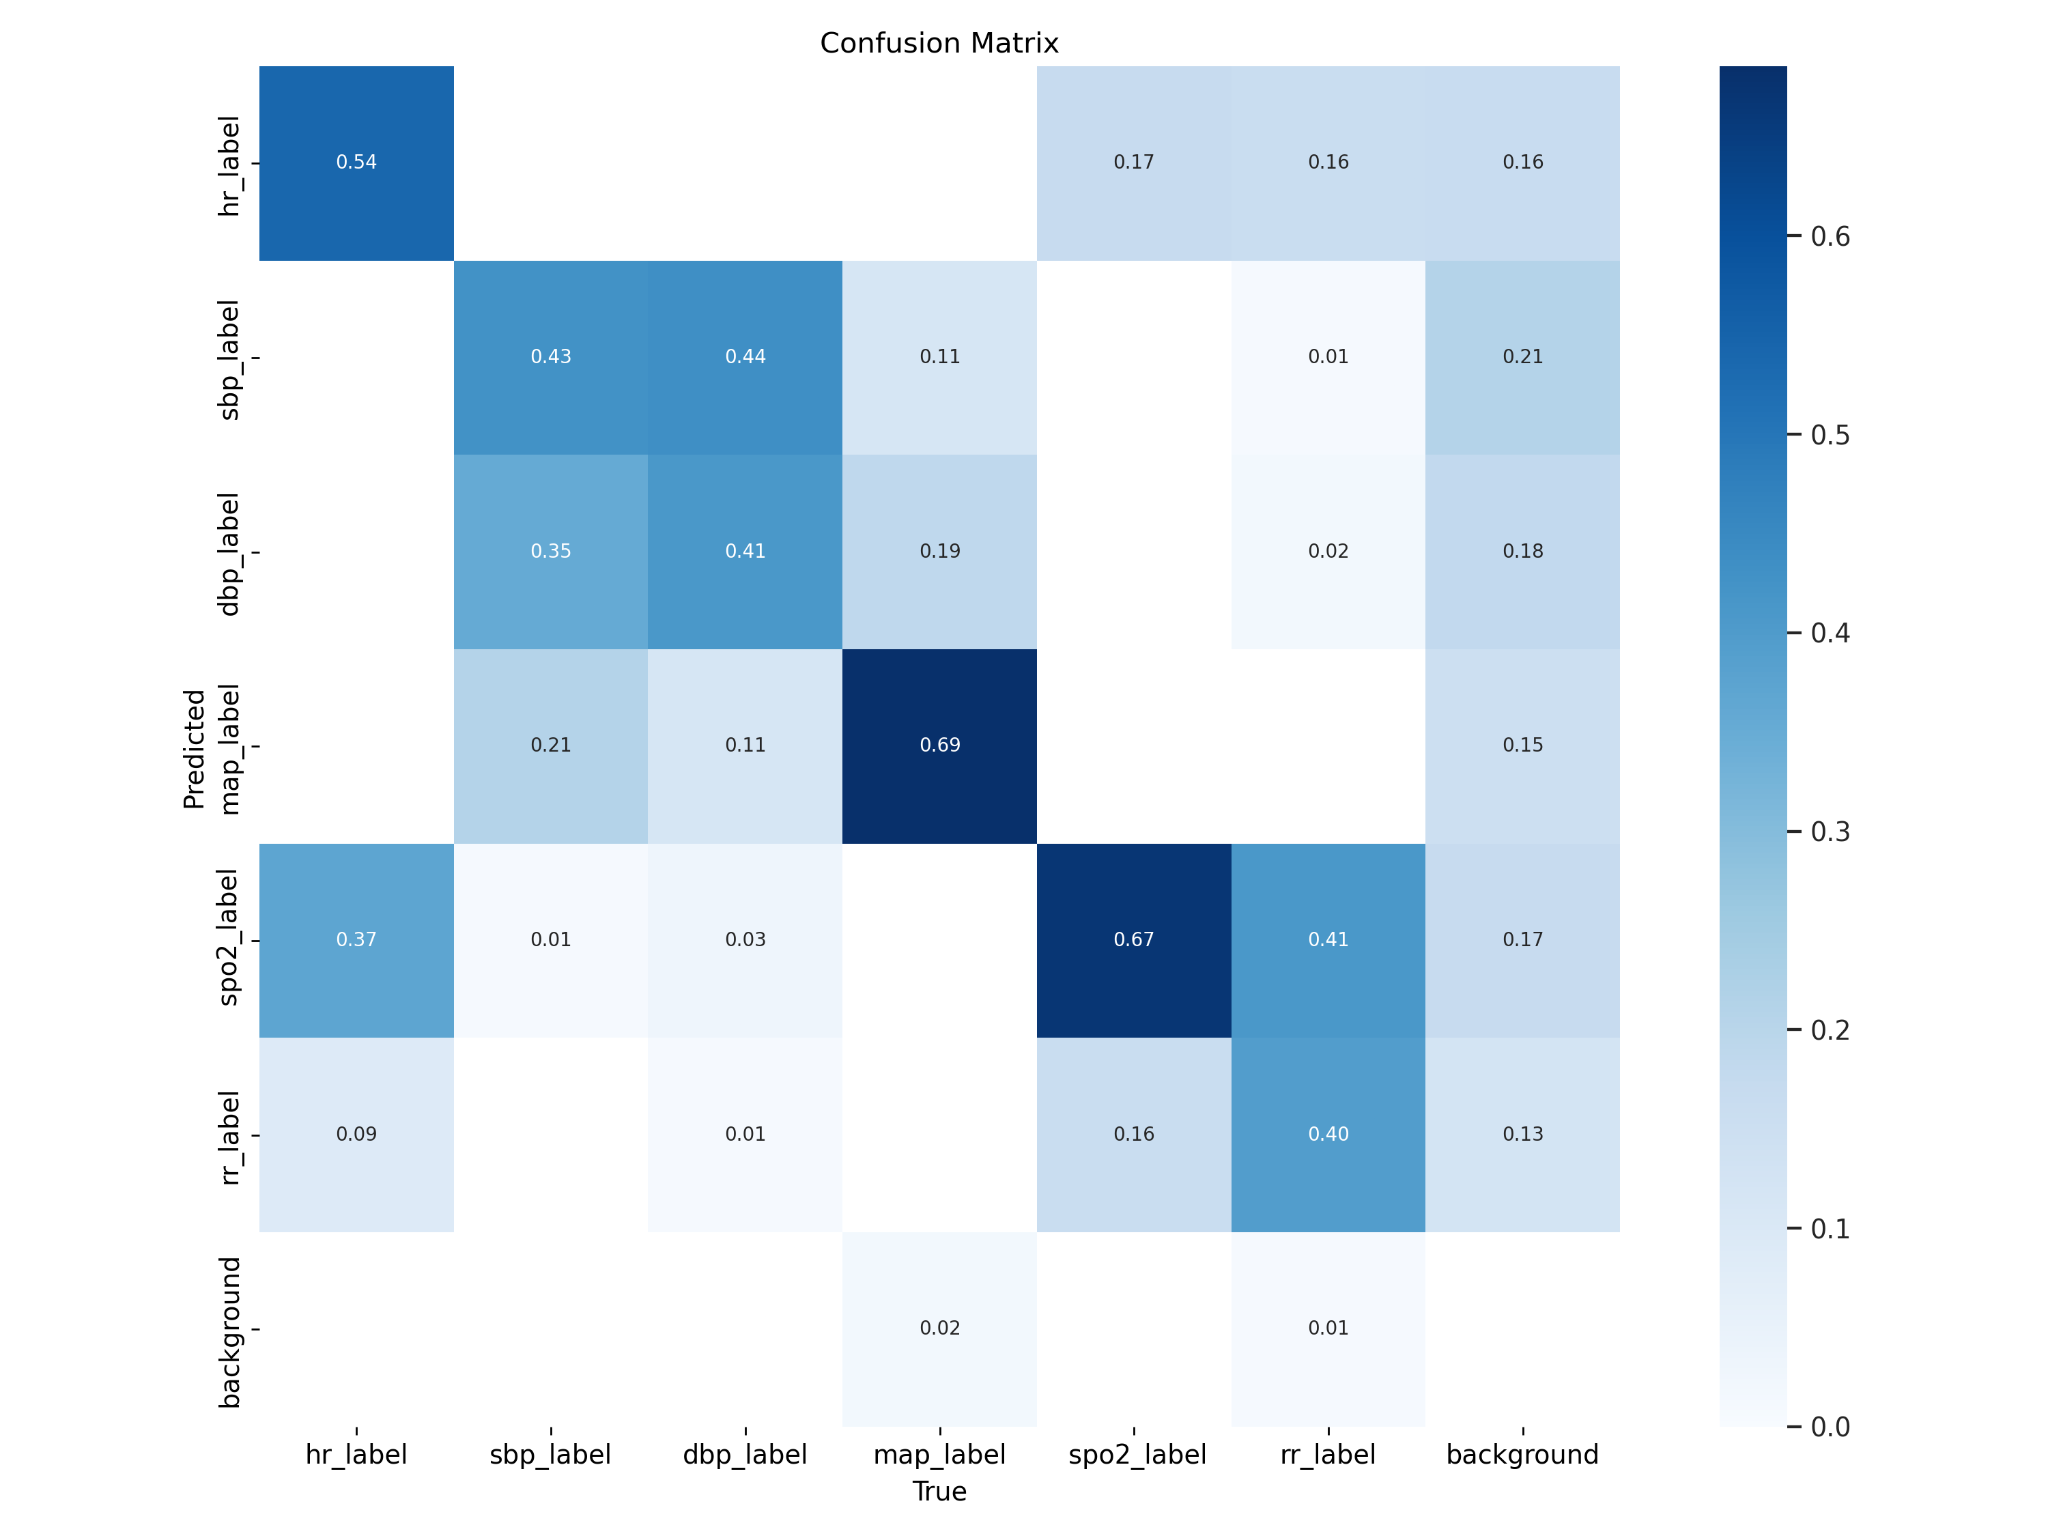

## Vital Classification
To accurately classify the digits in the monitors, an XGBoost model was specifically trained for
each of the four monitor classes. The position and size of the digit's bounding box was used as
input features for the model to make predictions on its class. The model was trained on a total of
around 250x6 samples per class, with a grid search performed to optimise the hyperparameters
of n_estimators and max_depth for improved accuracy. The final accuracy results for each class
were reported on test data (80/20 split).

- BPL-Ultima-PrimeD-A-classification: 100%
- BPL-EliteView-EV10-B_Meditec-England-A: 98.69%
- BPL-EliteView-EV100-C: 97.0%
- Nihon-Kohden-lifescope: 99%

## OCR
EasyOCR was employed for text detection and addressed the common problem of detecting a
mixture of alphanumeric characters faced by other OCRs. It provides a feature that allows you
to specify certain characters for recognition and ignore others, leading to improved accuracy
and reduced extraneous information. EasyOCR, Pyterreact, and Calamari OCR were tested,
and EasyOCR showed better accuracy compared to the other two. Also before being passed to
OCR, we are increasing the sharpness and using auto brightness to remove glare in the image.

## Heart Rate Digitization
We rotated the cropped image by an angle. This angle is the mean of lower and upper 40% of
all angles, which are made by lines joining the mean line and the peaks or the troughs. By doing
so we try to align all the peaks of the graph to get the same y-coordinate for all of the peaks.
Since there was some noise in the cropped image, we took the largest continuous contour to
get only the graph coordinates. Since Contour detects the border, it detects both the inner and
outer borders of the curve. This gives us multiple y-coordinates for a single x-coordinate. We
tried various methods to get a single y-coordinate for a given x-coordinate such as max, mean
and min. We found mean works the best in such cases. Hence we finally plot the obtained pairs
of (x,y) coordinates.

# Conclusion
In this study, we aimed to tackle the challenge of accurately recognizing and digitising heart rate
and reading the vitals from various monitoring devices in low-resource settings. Our work makes
a contribution in this direction by demonstrating use of open source models and data to achieve
satisfactory performance on the trained dataset. As future work, efforts can be directed towards
developing zero-shot or few-shot solutions to address this problem.

# Load the models and install relevant libraries

In [1]:
#Install relevant libraries
!pip install xgboost==1.7.3
!pip install easyocr

In [2]:
#Import necessary libraries

import torch
import pandas as pd
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
from tqdm import tqdm
import os
import shutil
import cv2
from PIL import Image, ImageOps, ImageEnhance
import easyocr
import math
#from google.colab.patches import cv2_imshow
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal

2023-02-10 10:09:39.694482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 10:09:39.815662: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 10:09:40.327796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-10 10:09:40.327834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
#Loading the models
monitor_segmenter = torch.hub.load('ultralytics/yolov5', 'custom', 'monitor_segment.pt')
kmeans_monitor_classifier = pickle.load(open("cluster_model", 'rb'))
digit_segmenter = torch.hub.load('ultralytics/yolov5', 'custom', 'digit-finder.pt')
hr_locator = torch.hub.load('ultralytics/yolov5', 'custom', 'hr_locator.pt')

xgb_NK_path = 'NK-A.pkl'
xgb_BPL_Ultima_path = 'BPL-Ultima-PrimeD-A.pkl'
xgb_BPL_EliteView_EV100 = 'BPL-EliteView-EV100-C.pkl'
xgb_BPL_EliteView_EV10 = 'BPL-EliteView-EV10-B_Meditec-England-A.pkl'

xgb_NK = pickle.load(open(xgb_NK_path, "rb"))
xgb_EV100 = pickle.load(open(xgb_BPL_EliteView_EV100, "rb"))
xgb_EV10 = pickle.load(open(xgb_BPL_EliteView_EV10, "rb"))
xgb_Ultima = pickle.load(open(xgb_BPL_Ultima_path, "rb"))

reader = easyocr.Reader(['en'])
model = InceptionV3(weights='imagenet', include_top=False)

Using cache found in /home/sharchit/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.9.13 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Using cache found in /home/sharchit/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.9.13 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Using cache found in /home/sharchit/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.9.13 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
2023-02-10 10:09:50.007476: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: ca

# Monitor segmentation

In [4]:
# Function to extract monitor bounding box by using YOLOv5
def getMonitorSegment(path: str):
    img = Image.open(path)
    predictions = monitor_segmenter(img)
    df = predictions.pandas().xywh[0]
    df = df[df.confidence==df.confidence.max()]
    # print(df)
    xcenter = df.iloc[0]['xcenter']
    ycenter = df.iloc[0]['ycenter']
    width = df.iloc[0]['width']
    height = df.iloc[0]['height']
    img = img.crop((xcenter - width / 2, ycenter - height / 2, xcenter + width / 2, ycenter + height/2))
    img = img.resize((416, 416))
    return img

# Inception v3 Model Classifier

In [5]:
# Function to Extract features from the images
# run once
def image_feature(imgarray):
    features = [];
    x = imgarray
    x=np.expand_dims(x,axis=0)
    x=preprocess_input(x)
    feat=model.predict(x)
    feat=feat.flatten()
    features.append(feat)
    return features

In [6]:
def getMonitorClass(img):
    res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
    img_features=image_feature(res)
    result = kmeans_monitor_classifier.predict((np.array(img_features[0]).reshape(-1,len(img_features[0])).astype(float)))
    return result

# Get Digits

In [7]:
def remove_glare(image):
    image = ImageEnhance.Sharpness(image).enhance(10)
    return ImageOps.autocontrast(image, cutoff=0)

## Functions for each of the 4 monitor classes

In [8]:
padding = 5

In [9]:
def getDigit_NK(image):
    #display(image)
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_NK.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        
        # display(digit)
        # print(label)
        # print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

In [10]:
def getDigit_BPL_EV100(image):
    #display(image)
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_EV100.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        # display(digit)
        # print(label)
        # print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

In [11]:
def getDigit_BPL_EV10(image):
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_EV10.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        
        # display(digit)
        # print(label)
        # print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

In [12]:
def getDigit_BPL_ultima(image):
    predictions = digit_segmenter(image)
    #predictions.show()
    df = predictions.pandas().xywh[0].sort_values(by = ['confidence'], ascending = False).head(6)
    digits = []
    read_digits = {
        'HR': None, 
        'SBP': None, 
        'DBP': None, 
        'MAP': None,
        'SPO2': None,
        'RR': None
    }
    
    for i in range(df.shape[0]):
        xcenter = df.iloc[i]['xcenter']
        ycenter = df.iloc[i]['ycenter']        
        width = df.iloc[i]['width']        
        height = df.iloc[i]['height']
        
        vector = xgb_Ultima.predict(np.array([xcenter/416, ycenter/416, width/416, height/416]).reshape(1, 4))
        label = np.argmax(vector)
        
        digit = image.crop((xcenter - width / 2 - padding, ycenter - height / 2 - padding, xcenter + width / 2 + padding, ycenter + height/2 + padding))
        digit = remove_glare(digit)
        digits.append(digit)
        
        #display(digit)
        #print(label)
        #print(readImage(digit))
        va = int(readImage(digit))
        leftout = []
        if label == 0:
          if read_digits['HR'] is None:
            if (va >= 40 and va <= 220):
              read_digits['HR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 1:
          if read_digits['SBP'] is None:
              if va <= 300:
                fin = readImage(digit)
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 1000 :
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 10000:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              elif va < 100000:
                fin = readImage(digit)[:2]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
              else:
                fin = readImage(digit)[:3]
                if (int(fin) >= 40 and int(fin) <= 240):
                  read_digits['SBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 2:
          if read_digits['DBP'] is None:
            if va <= 150:
              fin = readImage(digit)
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 2000:
              fin = readImage(digit)[1:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            elif va < 200000:
              fin = readImage(digit)[-2:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
            else:
              fin = readImage(digit)[-3:]
              if (int(fin) >= 40 and int(fin) <= 140):
                read_digits['DBP'] = fin
          else:
            leftout.append(readImage(digit))
        elif label == 3:
          if read_digits['MAP'] is None:
            read_digits['MAP'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        elif label == 4:
          if read_digits['SPO2'] is None:
            if(va >= 70 and va <= 100):
                read_digits['SPO2'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        else:
          if read_digits['RR'] is None:
            if (va >= 5 and va <=60):
              read_digits['RR'] = readImage(digit)
          else:
            leftout.append(readImage(digit))
        # print('\n\n')
    del read_digits['MAP']
    k = len(leftout)
    for key in read_digits:
      if read_digits[key] is None:
        #print(k)
        for i in range(k):
          if key == 'HR':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 220):
              read_digits['HR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 240):
              read_digits['SBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'DBP':
            if (int(leftout[i]) >= 40 and int(leftout[i]) <= 140):
              read_digits['DBP'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'RR':
            if (int(leftout[i]) >= 5 and int(leftout[i]) <= 60):
              read_digits['RR'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break
          elif key == 'SPO2':
            if (int(leftout[i]) >= 70 and int(leftout[i]) <= 100):
              read_digits['SPO2'] = leftout[i]
              leftout.pop(i)
              k -= 1
              break     
    keys_del = []
    for key in read_digits:
      if read_digits[key] is None:
        keys_del.append(key)
    for key in keys_del:
      del read_digits[key]
    return read_digits

# OCR

In [13]:
def readImage(image):
    result = reader.readtext(np.array(image), allowlist="0123456789()/")
    try:
        accu = result[0][2]
        ans = ''
        for char in result[0][1]:
            if char in '0123456789':
                ans += char
    except:
        ans = 0
    return ans

# HR Graph Digitization

In [14]:
def digitization(path):
    img = getMonitorSegment(path)
    predictions = hr_locator(img)
    df = predictions.pandas().xywh[0]
    df = df[df.confidence==df.confidence.max()]
    try:
        xcenter = df.iloc[0]['xcenter']
        ycenter = df.iloc[0]['ycenter']
        width = df.iloc[0]['width']
        height = df.iloc[0]['height']
    except:
        return
    
    img = img.crop((xcenter - width / 2 - 40, ycenter - height / 2 - 40, xcenter + width / 2 + 40, ycenter + height/2 + 40))
    # display(img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    # img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read input image as grayscale.

    threshed = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]  # threshold (binarize) the image

    # Apply closing for connecting the lines
    threshed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, np.ones((1, 10)))

    # Find contours
    contours = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # [-2] indexing takes return value before last (due to OpenCV compatibility issues).

    img2 = cv2.cvtColor(threshed, cv2.COLOR_GRAY2BGR)  # BGR image - used for drawing

    angles = []  # List of line angles.

    # Iterate the contours and fit a line for each contour
    # Remark: consider ignoring small contours
    for c in contours:
        vx, vy, cx, cy = cv2.fitLine(c, cv2.DIST_L2, 0, 0.01, 0.01) # Fit line
        w = img.shape[1]
        cv2.line(img2, (int(cx-vx*w), int(cy-vy*w)), (int(cx+vx*w), int(cy+vy*w)), (0, 255, 0))  # Draw the line for testing
        ang = (180/np.pi)*math.atan2(vy, vx) # Compute the angle of the line.
        angles.append(ang)

    angles = np.array(angles)  # Convert angles to NumPy array.

    # Remove outliers and 
    lo_val, up_val = np.percentile(angles, (40, 60))  # Get the value of lower and upper 40% of all angles (mean of only 10 angles)
    mean_ang = np.mean(angles[np.where((angles >= lo_val) & (angles <= up_val))])

    # print(f'mean_ang = {mean_ang}') 

    if(str(mean_ang) !="nan"):
        M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), mean_ang, 1)  # Get transformation matrix - for rotating by mean_ang

        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC) # Rotate the image

    # Uncommment to Display results rotated image
    # cv2_imshow( img)
    # cv2.waitKey()
    # cv2.destroyAllWindows()

    # Apply thresholding to create a binary image
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(len(contours))
    # Extract the largest contour (the graph)

    graph_contour = max(contours, key=cv2.contourArea)

    # Uncommment to Display results of contour in image
    # cv2.drawContours(img, graph_contour, -1, (0, 255, 0), 2)
    # cv2_imshow( img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Extract the coordinates of the graph points

    graph_points = graph_contour.reshape(-1, 2)

    #Uncomment to see the contour plot
    # x = [point[0] for point in graph_points]
    # y = [ point[1] for point in graph_points]
    # fig, ax = plt.subplots()
    # plt.gca().invert_yaxis()
    # ax.plot(x, y)
    # ax.scatter(x,y) 
    # plt.savefig("save.jpg")
    # plt.show()

    points2 = graph_points

    # print(graph_points)

    x_coordinates = np.unique([x for x, y in points2])
    y_coordinates = [np.mean ([y for x, y in points2 if x == x_coordinate]) for x_coordinate in x_coordinates]
    y_coordinates = [y_coordinate for y_coordinate in y_coordinates]


    # Show the plot
    # plt.show()

    plt.rcParams["figure.figsize"] = [20, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    ax.plot(x_coordinates, y_coordinates)
    ax.scatter(x_coordinates, y_coordinates)
    ax.grid(color='black', linestyle='--', linewidth=0.5)

    #To Adjust the graph
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    #set the aspect ratio to equal
    ax.set_aspect('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.savefig("digitized_graph.jpg")
    # graph = Image.open("/content/digitized_graph.jpg")
    # display(graph)
    plt.show()
    

# Inference

In [15]:
def inference(path):
  monitor_segmented = getMonitorSegment(path)
  classified_monitor = getMonitorClass(np.array(monitor_segmented))[0]
  #print(classified_monitor)
  if classified_monitor == 1:
      ans = getDigit_BPL_ultima(monitor_segmented)
  elif classified_monitor == 0:
      ans = getDigit_BPL_EV10(monitor_segmented)
  elif classified_monitor == 2:
      ans = getDigit_BPL_EV100(monitor_segmented)
  else:
      ans = getDigit_NK(monitor_segmented)
  return ans

In [16]:
inference('/home/sharchit/Documents/models2/prashant_icu_mon--1_2023_1_1_5_15_1.jpeg')

1/1 [==============================] - 1s 790ms/step


{'HR': '92', 'DBP': '82', 'SPO2': '98', 'RR': '26'}